In [2]:
#Libraries
import pandas as pd
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.model_selection import cross_val_score
import seaborn as sns
import math

In [3]:
#Read data for loans.
loans = pd.read_csv('C:/Users/phyuo/OneDrive/Υπολογιστής/Python_coding/JPMorgan/Task 3 and 4_Loan_Data.csv')
loans.head()

,customer_id,credit_lines_outstanding,loan_amt_outstanding,total_debt_outstanding,income,years_employed,fico_score,default
0,8153374,0,5221.545193,3915.471226,78039.38546,5,605,0
1,7442532,5,1958.928726,8228.752520,26648.43525,2,572,1
2,2256073,0,3363.009259,2027.830850,65866.71246,4,602,0
3,4885975,0,4766.648001,2501.730397,74356.88347,5,612,0
4,4700614,1,1345.827718,1768.826187,23448.32631,6,631,0


In [4]:
#Create new feature, ratio of total_debt_outstanding to income.
loans['ratio_tdo_to_income']=loans['total_debt_outstanding']/loans['income']
loans.head()

,customer_id,credit_lines_outstanding,loan_amt_outstanding,total_debt_outstanding,income,years_employed,fico_score,default,ratio_tdo_to_income
0,8153374,0,5221.545193,3915.471226,78039.38546,5,605,0,0.050173
1,7442532,5,1958.928726,8228.752520,26648.43525,2,572,1,0.308789
2,2256073,0,3363.009259,2027.830850,65866.71246,4,602,0,0.030787
3,4885975,0,4766.648001,2501.730397,74356.88347,5,612,0,0.033645
4,4700614,1,1345.827718,1768.826187,23448.32631,6,631,0,0.075435


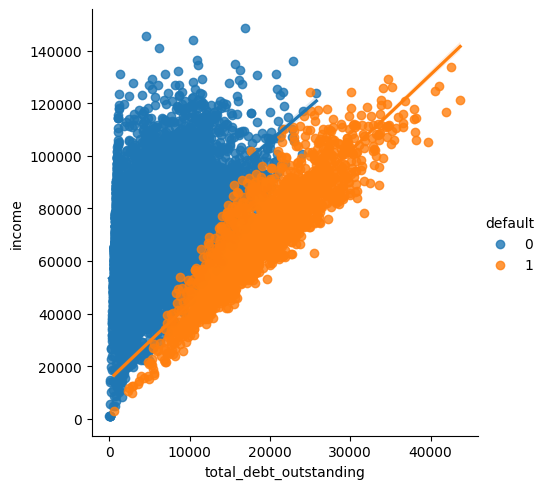

In [5]:
#Visualize the data
sns.lmplot(data = loans,x= 'total_debt_outstanding',y= 'income',hue='default')

<Axes: xlabel='years_employed', ylabel='income'>

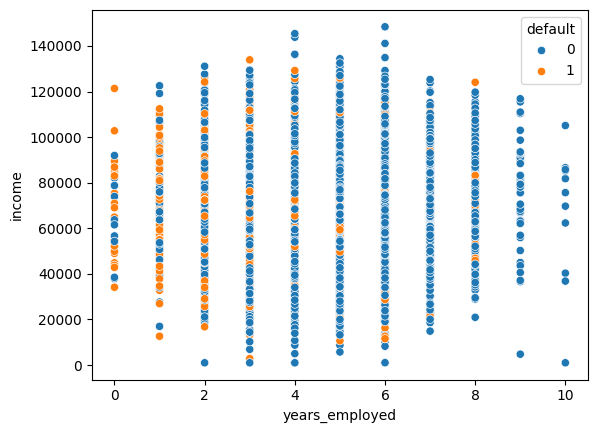

In [6]:
sns.scatterplot(data = loans,x= 'years_employed',y= 'income',hue='default')

<Axes: xlabel='ratio_tdo_to_income', ylabel='default'>

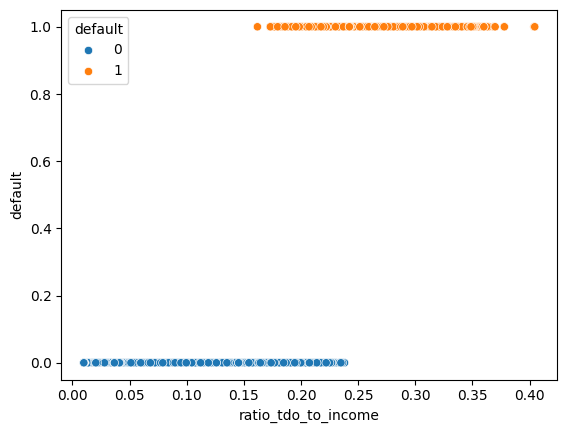

In [7]:
sns.scatterplot(data=loans,x='ratio_tdo_to_income',y='default',hue='default')

In [8]:
#We see from the above plots that we can seperate the default cases from the non default cases by constraining in various regions of the features.
#A randomforest classifier therefore should be a good first approach.

In [9]:
#Seperate features and target.
X= loans.drop(['customer_id','default'],axis=1)
y= loans['default']

In [10]:
#Features
X.head()

,credit_lines_outstanding,loan_amt_outstanding,total_debt_outstanding,income,years_employed,fico_score,ratio_tdo_to_income
0,0,5221.545193,3915.471226,78039.38546,5,605,0.050173
1,5,1958.928726,8228.752520,26648.43525,2,572,0.308789
2,0,3363.009259,2027.830850,65866.71246,4,602,0.030787
3,0,4766.648001,2501.730397,74356.88347,5,612,0.033645
4,1,1345.827718,1768.826187,23448.32631,6,631,0.075435


In [11]:
#Target
y.head()

0    0
1    1
2    0
3    0
4    0
Name: default, dtype: int64

In [12]:
#Split the data to train and validation sets.
X_train, X_valid, y_train, y_valid = train_test_split(X,y,test_size=0.2)


In [13]:
#Create model
classifier = RandomForestClassifier(n_estimators=100)
model = classifier.fit(X_train,y_train)
y_pred = model.predict(X_valid)


In [14]:
#Accuracy 
accuracy = accuracy_score(y_valid,y_pred)
accuracy

0.994

In [15]:
#Use cross-validation
scores = cross_val_score(classifier, X, y, cv=5)
scores

array([0.995 , 0.996 , 0.993 , 0.9935, 0.9945])

In [16]:
#Mean score and standard deviation 
print(f'The mean score is {scores.mean()}, and the standard deviation {scores.std()}')

The mean score is 0.9944000000000001, and the standard deviation 0.001067707825203124


In [17]:
#Expected return function
def expected_return(classifier,data,recovery_rate):

    prob_default = classifier.predict_proba(data)[0][1]
    money = data['loan_amt_outstanding']
    money_default = (1-recovery_rate)*money
    expected_return = -prob_default *money_default + (1-prob_default)*money


    return expected_return

In [18]:
#If expected return is negative this should be interpreted of course as the loss.
#Example
loss = expected_return(model,pd.DataFrame(X.iloc[1,:]).T,0.1)
loss
#End of task 3.

1   -1763.035853
Name: loan_amt_outstanding, dtype: float64

In [19]:
#Begin of Task 4.
print(f'min fico score {loans.fico_score.min()}, and max fico score {loans.fico_score.max()}')

min fico score 408, and max fico score 850


In [20]:
#Maximum log-likelihood
#LL(b1,..,br-1)= sum_i=1^r(ki logpi +(ni-ki)log(1-pi))
#bi boundareis of buckets, ni number of records in each bucket, ki number of defaults, and pi probability of defaulting.
#Intervals for buckets I1 = [408,b1) , I2= [b1,b2) , ..., Ir = [br-1,851)
#b1 = loans['fico_score'].sort_values(ascending=True)[:n1].max()
#b2 = loans['fico_score'].sort_values(ascending=True)[n1:n1+n2].max()
#.
#.
#.
#bn = loans['fico_score'].sort_values(ascending=True)[n1+...+nn-1:n1+...+nn].max().
#k1 = loans.loc[loans['fico_score'].sort_values(ascending=True)[:n1].index,'default'].sum()
#If we find the n's that maximize LL we can find the appropriate b's for the buckets.
#Let's take r=6.

In [21]:
#Define optimization function.
def optimization_function(params):
    n1,n2,n3,n4,n5 = params
    k1 = loans.loc[loans['fico_score'].sort_values(ascending=True)[:n1].index,'default'].sum()
    k2 = loans.loc[loans['fico_score'].sort_values(ascending=True)[n1:n1+n2].index,'default'].sum()
    k3 = loans.loc[loans['fico_score'].sort_values(ascending=True)[n1+n2:n1+n2+n3].index,'default'].sum()
    k4 = loans.loc[loans['fico_score'].sort_values(ascending=True)[n1+n2+n3:n1+n2+n3+n4].index,'default'].sum()
    k5 = loans.loc[loans['fico_score'].sort_values(ascending=True)[n1+n2+n3+n4:n1+n2+n3+n4+n5].index,'default'].sum()
    k6 = loans.loc[loans['fico_score'].sort_values(ascending=True)[n1+n2+n3+n4+n5:].index,'default'].sum()
    n6 = loans.loc[loans['fico_score'].sort_values(ascending=True)[n1+n2+n3+n4+n5:].index,'default'].count()
    p1 = k1/n1 
    p2 = k2/n2 
    p3 = k3/n3 
    p4 =k4/n4 
    p5 = k5/n5 
    p6= k6/n6
    return k1*math.log(p1) + (n1-k1)*math.log(1-p1)+ k2*math.log(p2) + (n2-k2)*math.log(1-p2)+ k3*math.log(p3) + (n3-k3)*math.log(1-p3)+ k4*math.log(p4) + (n4-k4)*math.log(1-p4)+ k5*math.log(p5) + (n5-k5)*math.log(1-p5)+ k6*math.log(p6) + (n6-k6)*math.log(1-p6)

In [22]:
optimization_function([115,400,1400,1400,4000])

-4267.571129018654

In [23]:
#Calculate boundaries for buckets.
b1 = loans['fico_score'].sort_values(ascending=True)[:115].max()
b2 = loans['fico_score'].sort_values(ascending=True)[115:515].max()
b3 = loans['fico_score'].sort_values(ascending=True)[515:1915].max()
b4 = loans['fico_score'].sort_values(ascending=True)[1915:3315].max()
b5 = loans['fico_score'].sort_values(ascending=True)[3315:7315].max()
print(b1,b2,b3,b4,b5)

494 537 585 612 675


In [24]:
#Rating map 
map = {range(408,b1):6, range(b1,b2):5 , range(b2,b3):4 , range(b3,b4):3 , range(b4,b5):2 , range(b5,850):1}

In [25]:
#Create rating feature
loans['rating']= loans.fico_score.apply(lambda x: next((v for k, v in map.items() if x in k), 0))

In [26]:
loans.head()

,customer_id,credit_lines_outstanding,loan_amt_outstanding,total_debt_outstanding,income,years_employed,fico_score,default,ratio_tdo_to_income,rating
0,8153374,0,5221.545193,3915.471226,78039.38546,5,605,0,0.050173,3
1,7442532,5,1958.928726,8228.752520,26648.43525,2,572,1,0.308789,4
2,2256073,0,3363.009259,2027.830850,65866.71246,4,602,0,0.030787,3
3,4885975,0,4766.648001,2501.730397,74356.88347,5,612,0,0.033645,2
4,4700614,1,1345.827718,1768.826187,23448.32631,6,631,0,0.075435,2


In [28]:
#Train a model with only the ratings
X_2 = loans['rating'].to_numpy().reshape(-1,1)
y_2 = loans['default']

X_train_2 , X_valid_2 , y_train_2 , y_valid_2 =train_test_split(X_2,y_2,test_size=0.2)

classifier_2 =RandomForestClassifier(n_estimators=100)
model_2 = classifier_2.fit(X_train_2,y_train_2)
y_pred_2 = model_2.predict(X_valid_2)
score_2 = accuracy_score(y_valid_2,y_pred_2)
print(score_2)

0.825


In [29]:
#With cross validation 
scores_2 = cross_val_score(classifier_2, X_2, y_2, cv=5)
print(f'mean score {scores_2.mean()}, and standard deviation {scores_2.std()}')
#The model doesn't perform as good as the previous one, but considered that it only takes one feature it still gives a good performace.

mean score 0.8228, and standard deviation 0.002158703314492284
